#Part One - Preprocessing

In [1]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
housing = pd.read_csv("/content/housing.csv")
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

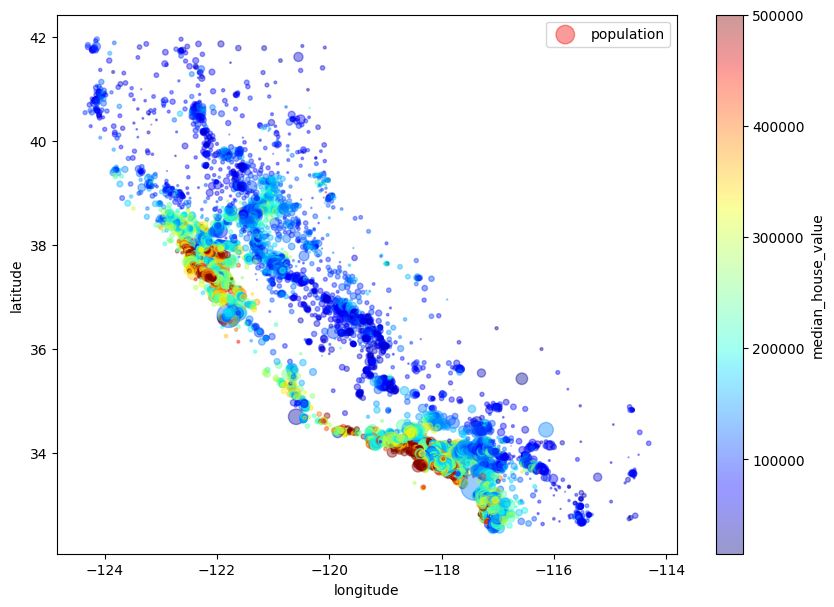

In [3]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]

        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [5]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(housing.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
feat_names = list(housing.drop("ocean_proximity", axis=1).columns)
feat_names.extend(["rooms_per_household", "population_per_household", "bedrooms_per_room"])
feat_names.extend(set(housing["ocean_proximity"]))
print(feat_names)
housing_prepared = full_pipeline.fit_transform(housing)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'rooms_per_household', 'population_per_household', 'bedrooms_per_room', 'NEAR OCEAN', 'ISLAND', 'INLAND', '<1H OCEAN', 'NEAR BAY']


# Part Two - K-Means Implementation

In [6]:
import math

In [7]:
class MyKMeans:
  """
  clusters
  """

  def __init__ (self, n_clusters, dist_algo, iters=300):
    self.n_clusters = n_clusters;
    self.dist_algo = dist_algo;
    self.cluster_centers_ = None
    self.labels_ = None
    self.sse_ = -1
    self.sd_ = None
    self.iters_ = iters

  def compute_dist(self, x, y):
    if self.dist_algo == "manhattan": return np.sum(np.abs(x - y))
    elif self.dist_algo == "euclidean": return np.sqrt(np.sum((x - y) ** 2))
    elif self.dist_algo == "sup": return np.max(np.abs(x - y))
    else: print("invalid distance algorithm")

  def sort_pts(self, arr):
    sse = 0
    dists = []
    for x in arr:
      dists_from_centers = []
      for y in self.cluster_centers_:
        dists_from_centers.append(self.compute_dist(x, y))
      sse = sse + min(dists_from_centers)
      dists.append(dists_from_centers)
    self.labels_ = np.argmin(dists, axis=1)
    self.sse_ = sse


  def fit(self, arr):
    # select random initial centroids
    center_idx = np.random.choice(arr.shape[0], self.n_clusters, replace=False)
    self.cluster_centers_ = arr[center_idx]
    self.sort_pts(arr)

    # reevaluate and repeat
    for _ in range(self.iters_):
      means = []
      sd = []
      for i in range(self.n_clusters):
        cluster = arr[self.labels_ == i]
        if cluster.size == 0:
          print("cluster " + str(i) + " is empty")
          idx = np.random.choice(arr.shape[0], 1, replace=False)
          means.append(arr[idx])
        else:
          means.append(cluster.mean(axis=0))
          sd.append(cluster.std(axis=0))
      self.cluster_centers_ = means
      self.sort_pts(arr)
      self.sd_ = np.array(sd)

# Part Three - Clustering Housing

## Sup Distance

---2 MANY CLUSTERS---
the standard square error is 31929.976212408095
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.320515  35.987982           32.373139  3124.171319      616.969153   
1 -119.979824  35.045752           22.494587  1831.933655      404.959242   

    population  households  median_income  median_house_value  \
0  1398.058164  394.019332       4.644402       246590.349116   
1  1470.602645  673.206613       4.822142       238362.893881   

   rooms_per_household  population_per_household  bedrooms_per_room  \
0             5.429385                  4.384351           0.221737   
1             5.429951                  3.957329           0.222953   

   NEAR OCEAN    ISLAND    INLAND  <1H OCEAN  NEAR BAY  
0   -0.273147  0.277409 -0.343772   0.233915  0.168254  
1    0.449550 -0.456564  0.565785  -0.384980 -0.276915  
FEATURE STANDARD DEVIATIONS
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \


<ipython-input-19-6813f87731d8>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


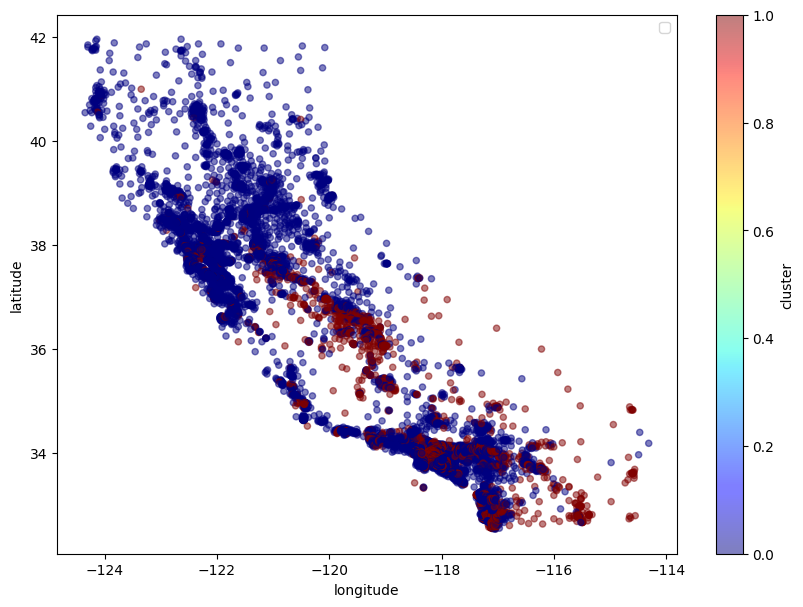



---3 MANY CLUSTERS---
the standard square error is 29577.931907214905
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -120.217043  35.057281           38.794370  4764.765951      697.153291   
1 -118.742458  36.396005           24.349003  1855.387808      436.181221   
2 -120.106267  35.113047           24.682234  1636.397604      521.267274   

    population  households  median_income  median_house_value  \
0  1391.117885  328.597684       5.023030       218585.783129   
1  1468.387133  647.257932       4.851129       243094.552072   
2  1398.418520  458.609940       4.203965       268715.688688   

   rooms_per_household  population_per_household  bedrooms_per_room  \
0             5.430652                  4.547654           0.223509   
1             5.429287                  3.321642           0.223293   
2             5.429000                  5.184944           0.219334   

   NEAR OCEAN    ISLAND    INLAND  <1H OCEAN  NEAR BAY  
0 

<ipython-input-19-6813f87731d8>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


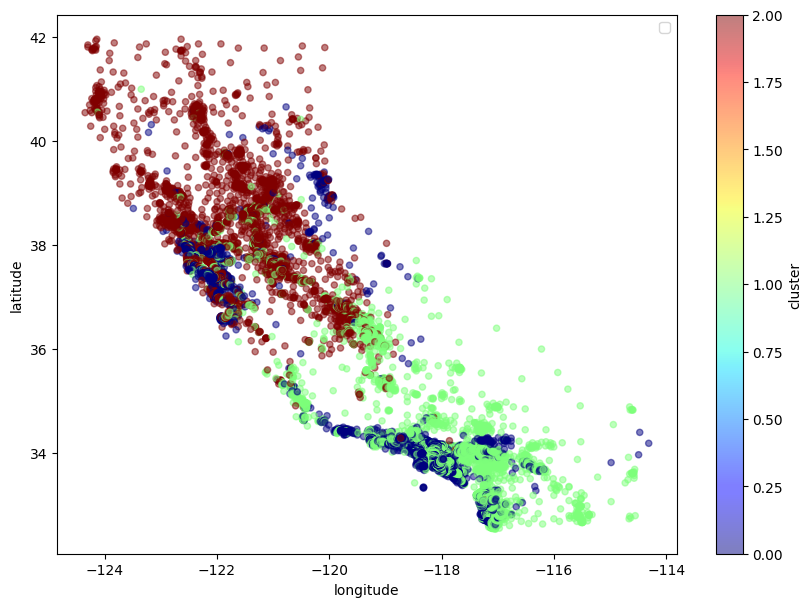



---4 MANY CLUSTERS---
the standard square error is 28914.012183388913
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -118.809656  36.548128           37.093327  4048.458064      622.760865   
1 -120.105036  35.116728           24.971301  1740.823932      520.830978   
2 -119.937048  35.052062           21.858368  1794.227727      381.934434   
3 -121.483158  33.605597           26.619383  1931.555498     3696.435364   

    population   households  median_income  median_house_value  \
0  1399.801677   354.119513       4.948857       230043.186656   
1  1445.251400   458.072977       4.177588       266485.424433   
2  1438.349394   708.045398       4.968607       235708.596008   
3  1383.309908  1201.225129       4.019091       307824.534763   

   rooms_per_household  population_per_household  bedrooms_per_room  \
0             5.429630                  3.889820           0.223737   
1             5.429000                  5.553967       

<ipython-input-19-6813f87731d8>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


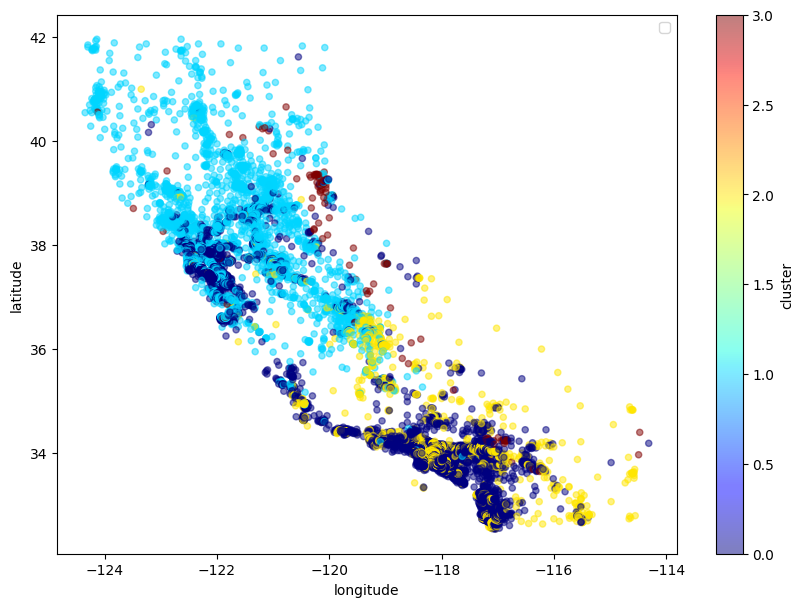



---5 MANY CLUSTERS---
the standard square error is 26560.85512529932
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -120.388392  34.817696           22.114274  1487.531274      471.054678   
1 -120.079986  34.860067           24.276892  1825.485151      441.520591   
2 -117.378081  38.032968           25.643968  2267.181113      435.895196   
3 -120.190903  35.156765           45.112301  5972.972141      818.956524   
4 -119.769721  35.482603           28.870451  2154.751773      585.832447   

    population  households  median_income  median_house_value  \
0  1395.057475  520.472162       4.082390       259124.823635   
1  1492.906958  558.011250       5.053191       233708.840434   
2  1413.602520  721.115448       4.849790       241470.776044   
3  1380.071073  255.987176       4.952620       218292.012119   
4  1400.859846  383.640104       4.347521       271453.563841   

   rooms_per_household  population_per_household  bedrooms_pe

<ipython-input-19-6813f87731d8>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


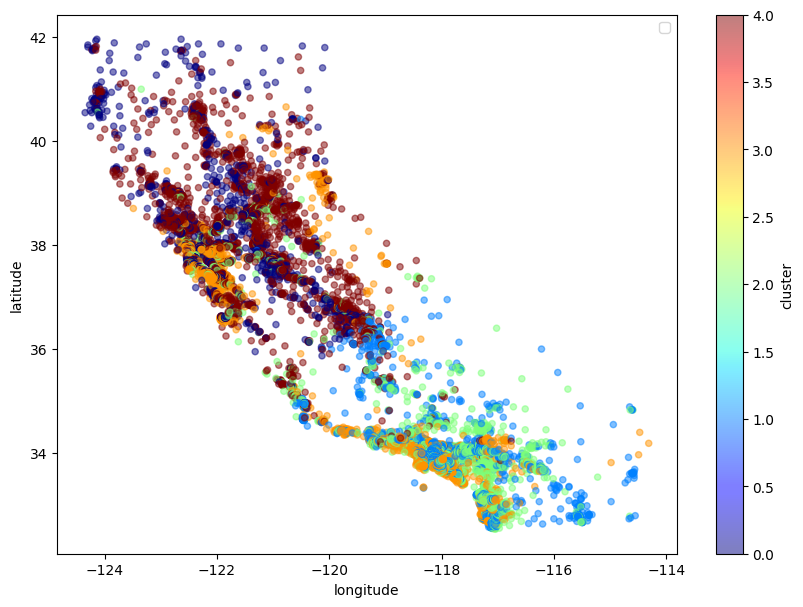



---6 MANY CLUSTERS---
the standard square error is 25335.8224471175
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -114.691260  41.169082           30.139885  2731.342156      546.638654   
1 -119.911550  35.026318           19.172654  1719.133488      300.580483   
2 -119.866974  35.345832           24.928712  1337.036719      554.301268   
3 -119.618138  35.448260           27.379894  2032.625018      501.762453   
4 -120.133950  35.181847           44.777789  5839.474197      808.921401   
5 -120.392519  34.856397           23.690910  2041.255307      472.955099   

    population  households  median_income  median_house_value  \
0  1402.527656  482.039316       4.721979       249523.402735   
1  1450.245732  923.564000       5.144323       226069.895299   
2  1402.831386  430.458199       4.180098       287770.131020   
3  1426.217166  471.484442       4.949807       238446.485630   
4  1460.901950  253.329041       4.949802       219

<ipython-input-19-6813f87731d8>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


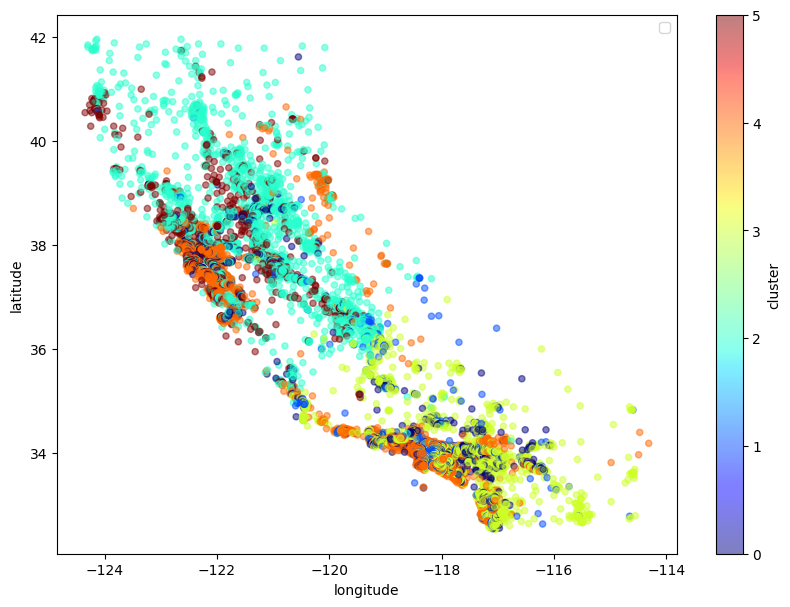



---7 MANY CLUSTERS---
the standard square error is 25147.034488830326
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -120.379228  34.724567           65.099357  6290.286189     1748.095690   
1 -120.000783  35.336426           40.049218  5339.866593      651.571426   
2 -114.503036  41.393533           30.352569  2729.963909      552.474806   
3 -119.311345  35.794350           26.439827  1728.646237      508.006595   
4 -119.603238  35.559144           17.556553  2283.958882      176.825337   
5 -120.217606  35.002557           23.361956  1446.620698      511.704454   
6 -120.094891  34.830032           24.034677  1821.950172      437.670147   

    population   households  median_income  median_house_value  \
0  1404.803155   107.806341       4.737960       240379.027580   
1  1454.344589   296.158668       4.927090       219202.929745   
2  1400.920042   469.980970       4.702886       250773.979899   
3  1423.732388   481.547246      

<ipython-input-19-6813f87731d8>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


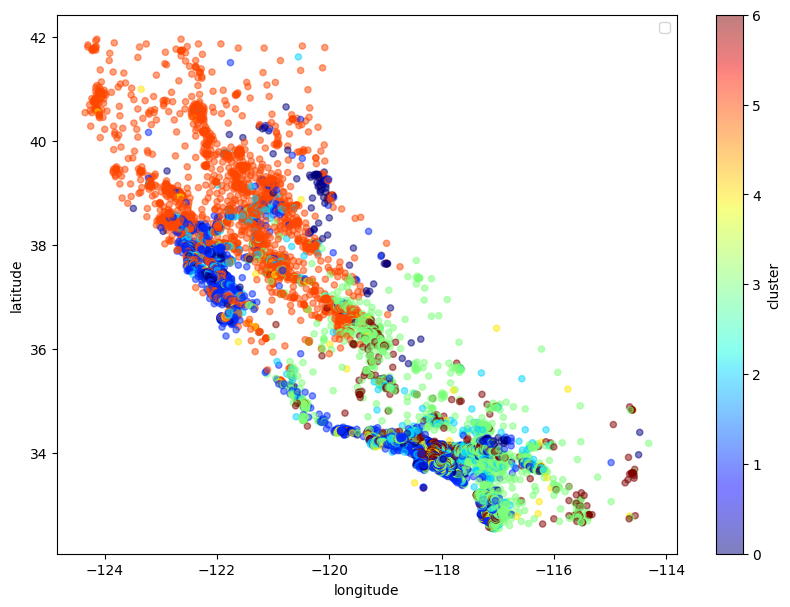



---8 MANY CLUSTERS---
the standard square error is 23817.151666373073
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -114.473260  41.434582           30.576101  2781.452126      557.910728   
1 -120.390896  34.836954           23.430332  1904.246006      475.034148   
2 -119.129745  35.872705           20.512345  1530.160083      354.136912   
3 -119.741459  35.401683           34.015714  2711.921073      820.566301   
4 -119.869708  35.408063           16.611881  2500.592171      133.073412   
5 -119.854845  35.353923           25.214465  1390.025815      556.168282   
6 -120.187281  35.197442           46.869057  6456.942074      701.315177   
7 -120.198990  34.761077           25.809847  2116.573117      462.699840   

    population   households  median_income  median_house_value  \
0  1400.481382   466.035105       4.707032       250324.519300   
1  1392.095438   501.439194       4.123708       248191.765893   
2  1440.956316   738.8

<ipython-input-19-6813f87731d8>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


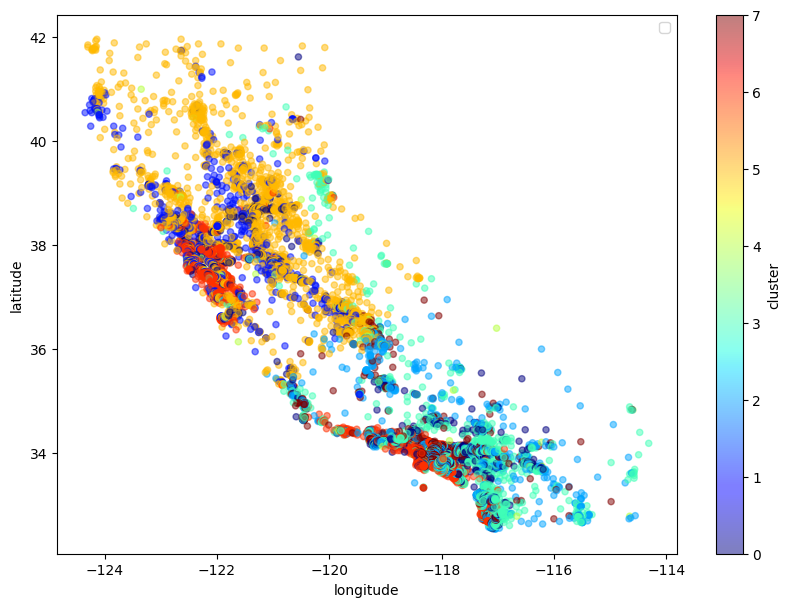



---9 MANY CLUSTERS---
the standard square error is 23365.041903487127
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -120.228294  34.704757           29.571484  1956.300863      553.152247   
1 -119.801739  35.402731           25.849927  1484.597963      565.321213   
2 -120.227460  35.323006           34.292688  5592.649908      545.922442   
3 -120.108257  35.095727           50.419776  5917.966934      961.540070   
4 -119.932212  34.980845           21.014538  1841.259199      369.121973   
5 -120.433732  34.751134           21.336759  1183.872251      468.673762   
6 -119.599073  35.612585           17.364938  2284.508905      151.953694   
7 -114.235342  41.688036           30.696953  2785.162233      561.303079   
8 -119.098360  36.078320           26.295576  2075.519902      477.548976   

    population   households  median_income  median_house_value  \
0  1566.256523   366.514360       5.041472       244484.957926   
1  1403.994

<ipython-input-19-6813f87731d8>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


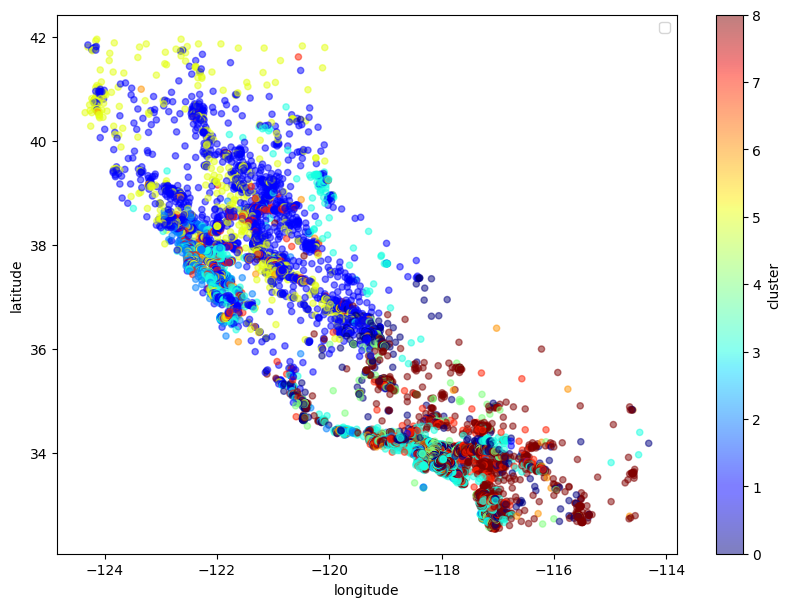



---10 MANY CLUSTERS---
the standard square error is 22626.710928266948
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.603087  35.537694           24.439715  1627.441028      457.693890   
1 -116.342668  39.261635           28.209585  2528.377476      503.293386   
2 -120.184538  34.906108           32.470313  2909.205918      571.523687   
3 -120.437944  34.744638           21.999486  1349.341517      470.382180   
4 -119.707899  35.479345           16.720212  2269.370920      136.855551   
5 -119.980983  35.153148           52.633623  5688.608811     1034.289102   
6 -120.256353  35.323204           34.826705  5875.374000      542.391733   
7 -119.905423  34.906661           20.533310  1431.020525      378.416999   
8 -119.932056  35.273807           25.069950  1336.820602      559.478043   
9 -109.098861  46.948871           33.815212  2894.907429      646.466739   

    population   households  median_income  median_house_value  \

<ipython-input-19-6813f87731d8>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


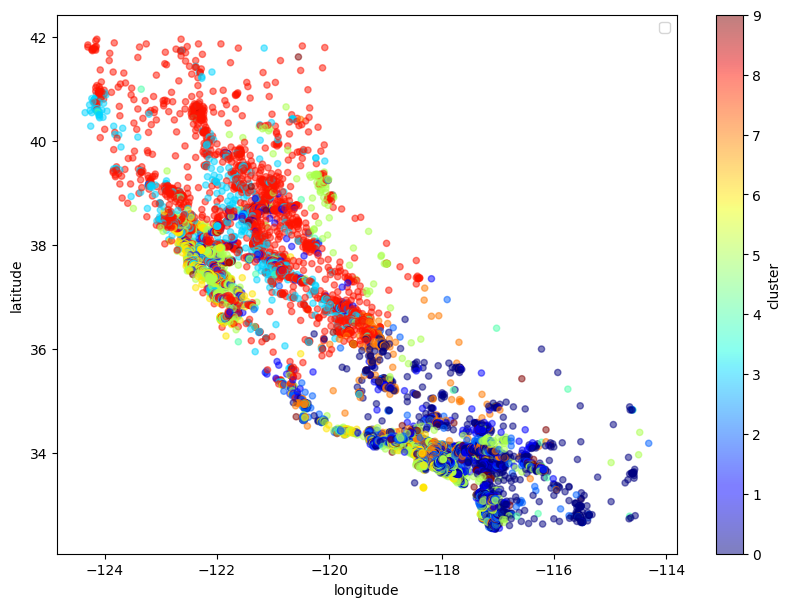

In [19]:
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
errors = {}
for k in ks:
  kmeans = MyKMeans(k, dist_algo="sup", iters=100)
  kmeans.fit(housing_prepared)

  housing_w_other_features = np.hstack((housing, housing_prepared[:,:7]))
  labeled = np.hstack((housing_w_other_features, kmeans.labels_.reshape(-1, 1)))
  labeled_df = pd.DataFrame(labeled, columns=feat_names + ['cluster'])

  errors[k] = kmeans.sse_
  print("---" + str(k) + " MANY CLUSTERS" + "---")
  print("the standard square error is " + str(kmeans.sse_))

  scaler = full_pipeline.named_transformers_["num"].named_steps["std_scaler"]
  cluster_vals = scaler.inverse_transform(np.array(kmeans.cluster_centers_)[:,5:])
  cluster_vals = np.hstack((cluster_vals, np.array(kmeans.cluster_centers_)[:,:5]))
  means = pd.DataFrame(cluster_vals, columns=feat_names)
  print("FEATURE MEANS")
  print(means)

  print("FEATURE STANDARD DEVIATIONS")
  print(pd.DataFrame(kmeans.sd_, columns=feat_names))

  labeled_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, figsize=(10,7),
      c="cluster", cmap=plt.get_cmap("jet"))
  plt.legend()
  plt.show()
  print('\n')

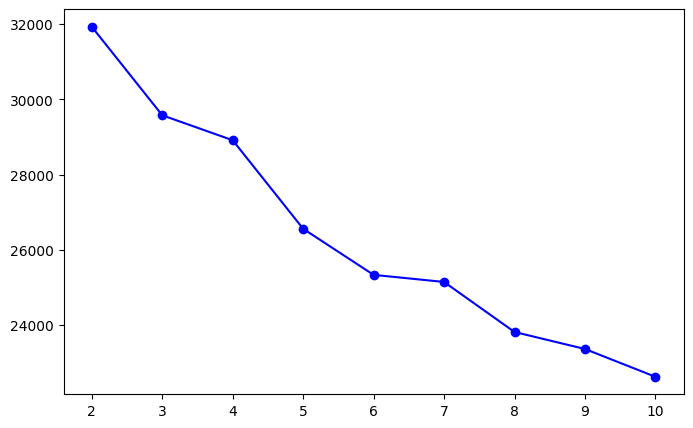

In [20]:
ks = list(errors.keys())
sse_values = list(errors.values())
plt.figure(figsize=(8, 5))
plt.plot(ks, sse_values, marker='o', linestyle='-', color='b')
plt.show()

##Euclidean Distance

---2 MANY CLUSTERS---
the standard square error is 57357.960117450995
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -117.557852  37.980456           36.415895  3726.874160      657.106949   
1 -120.202565  34.893074           26.193293  2292.536687      499.006610   

    population  households  median_income  median_house_value  \
0  1400.831649  383.094459       4.881141       236107.044110   
1  1433.229252  536.169382       4.658241       245800.250723   

   rooms_per_household  population_per_household  bedrooms_per_room  \
0             5.429000                  3.909678           0.222526   
1             5.429788                  4.321502           0.222093   

   NEAR OCEAN    ISLAND    INLAND  <1H OCEAN  NEAR BAY  
0    0.186946 -0.226604 -0.686107   1.164983  1.092500  
1   -0.058807  0.071282  0.215826  -0.366464 -0.343663  
FEATURE STANDARD DEVIATIONS
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \


<ipython-input-10-fb4a0590dd97>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


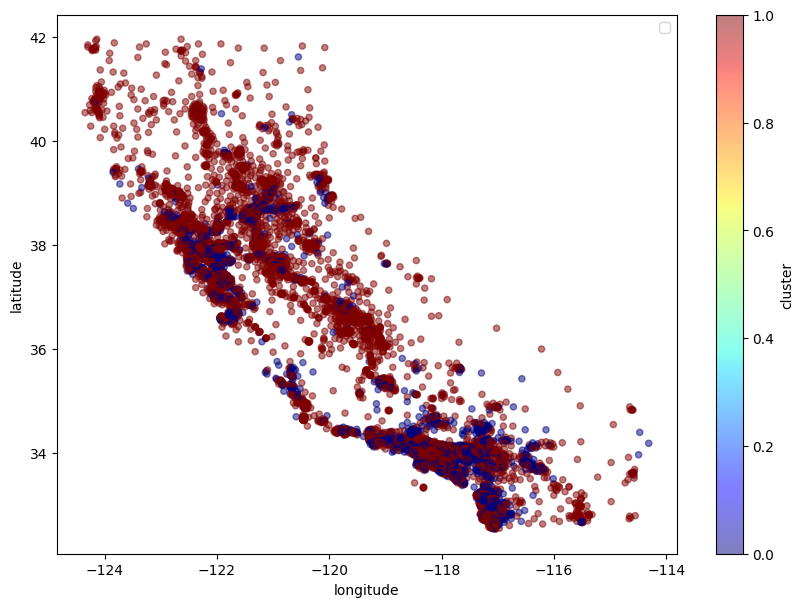



---3 MANY CLUSTERS---
the standard square error is 50785.65043692625
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.853120  35.215480           28.931250  2806.006991      496.663306   
1 -115.142921  40.733080           31.091399  2952.095476      561.398953   
2 -120.133957  35.095414           27.758347  2354.059988      582.623252   

    population  households  median_income  median_house_value  \
0  1444.069569  539.495888       5.109374       228680.396156   
1  1396.649748  482.239031       4.756650       247266.528597   
2  1407.930331  452.518983       4.198124       261444.911748   

   rooms_per_household  population_per_household  bedrooms_per_room  \
0             5.430171                  3.070655           0.224127   
1             5.429000                  3.900802           0.220548   
2             5.429000                  5.750258           0.220094   

   NEAR OCEAN    ISLAND    INLAND  <1H OCEAN  NEAR BAY  
0  

<ipython-input-10-fb4a0590dd97>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


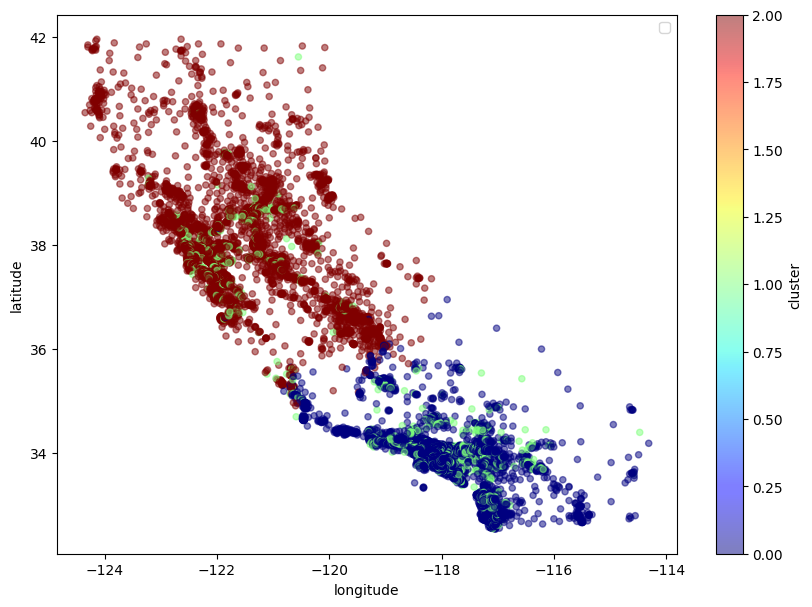



---4 MANY CLUSTERS---
the standard square error is 47754.29424051268
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -120.062117  35.151070           47.796084  5763.069725      845.293073   
1 -119.760679  35.278899           24.038333  2039.351156      420.826496   
2 -120.115305  35.116519           24.559009  1816.673173      521.855549   
3 -114.857947  41.061974           30.254033  2772.071371      553.689779   

    population  households  median_income  median_house_value  \
0  1412.923647  179.341465       5.041720       219315.286167   
1  1433.551685  640.646164       5.058256       231909.647455   
2  1428.254376  490.484907       4.147727       267125.896562   
3  1396.234581  484.650574       4.729829       249518.919449   

   rooms_per_household  population_per_household  bedrooms_per_room  \
0             5.429000                  4.164852           0.224903   
1             5.430468                  3.071888           0.

<ipython-input-10-fb4a0590dd97>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


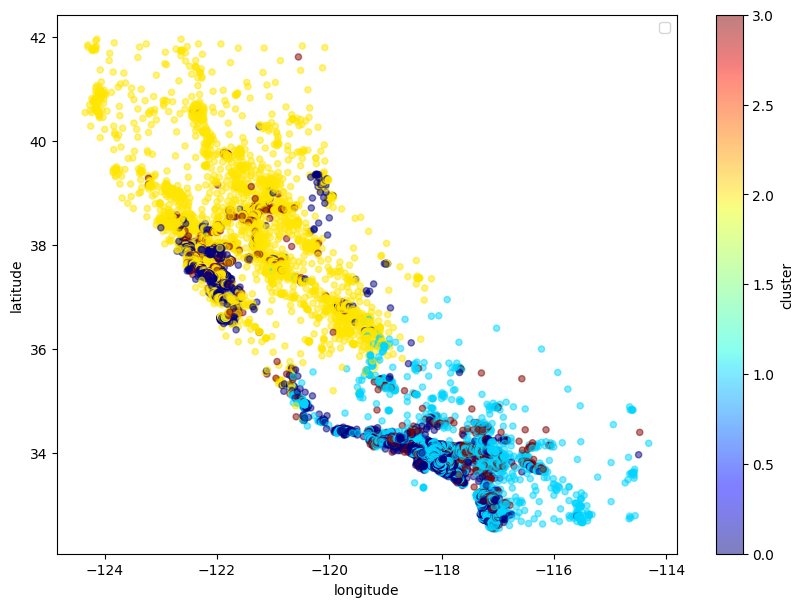



---5 MANY CLUSTERS---
the standard square error is 46258.22034174766
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.742083  35.187728           19.030515  1687.408758      305.663219   
1 -119.744029  35.426762           31.407776  2839.241410      575.451091   
2 -120.184327  35.041981           52.225380  6531.733977      922.034762   
3 -120.103385  35.131518           24.663688  1812.408041      525.099473   
4 -114.634946  41.332107           30.524216  2784.465355      555.423657   

    population  households  median_income  median_house_value  \
0  1449.586706  882.300040       5.071167       229682.213661   
1  1413.100367  369.377255       5.067866       232414.452919   
2  1418.118734  149.343821       4.909306       218101.071647   
3  1428.379097  478.833714       4.153560       267189.499927   
4  1395.183366  473.066580       4.715167       249890.648284   

   rooms_per_household  population_per_household  bedrooms_pe

<ipython-input-10-fb4a0590dd97>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


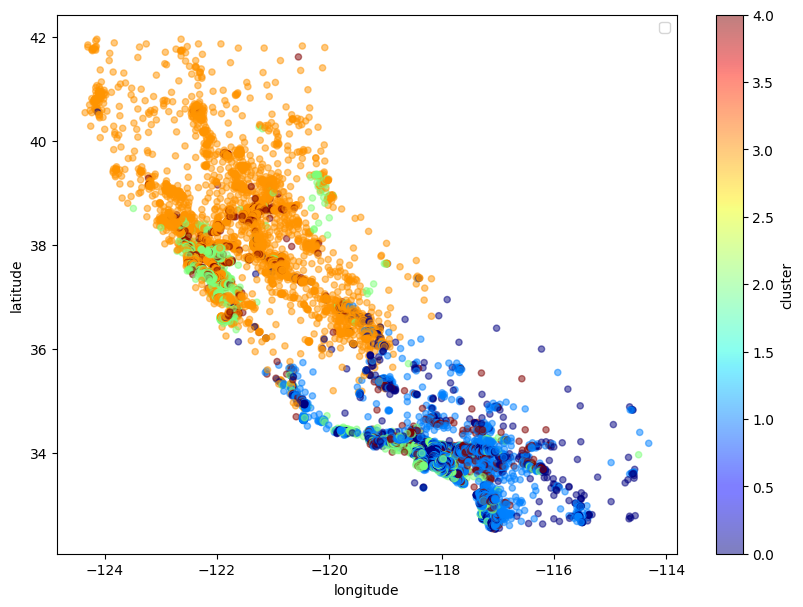



---6 MANY CLUSTERS---
the standard square error is 44375.31322593459
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -116.924293  38.744958           28.632300  2683.741645      512.428774   
1 -120.143439  35.141285           38.779085  4787.292983      702.882748   
2 -119.867343  35.096022           21.530936  1768.090574      371.806567   
3 -120.172900  35.014195           41.222623  4555.870219      697.201836   
4 -110.011645  46.212703           32.298495  2774.268330      620.302365   
5 -120.255088  34.908458           21.658695   989.126648      522.777765   

    population  households  median_income  median_house_value  \
0  1400.660989  524.801369       4.778167       245145.252770   
1  1483.575716  309.844984       4.405669       218091.965446   
2  1443.608112  732.528435       5.043055       231439.839541   
3  1400.400002  248.761268       5.253974       220933.919579   
4  1403.368098  416.513348       4.611895       25

<ipython-input-10-fb4a0590dd97>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


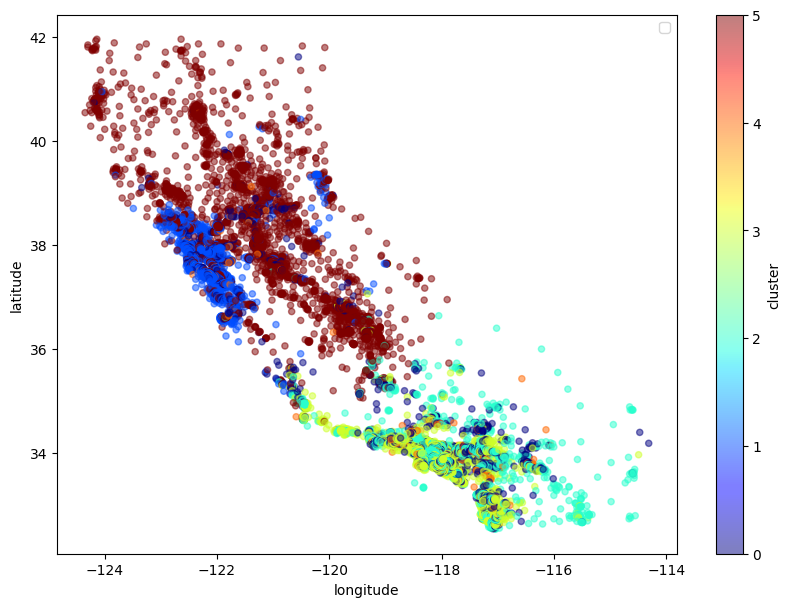



---7 MANY CLUSTERS---
the standard square error is 43824.34452874502
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.682887  35.155856           17.238341  1713.476502      235.559889   
1 -120.251200  34.966709           24.594167  1831.550542      528.620147   
2 -120.128439  35.050776           52.312714  6268.130011      935.180216   
3 -120.353920  34.755974           30.314387  3171.656514      515.296825   
4 -116.607439  39.179670           29.561483  2899.922053      521.074604   
5 -109.408433  46.780935           32.863614  2811.176649      624.090840   
6 -119.418743  35.705729           25.399604  1538.013845      520.446742   

    population   households  median_income  median_house_value  \
0  1463.430792  1094.622099       5.158600       222462.622712   
1  1406.217408   471.587690       4.146099       266310.882969   
2  1492.964720   136.719112       4.914140       219632.528497   
3  1415.033638   414.245230       

<ipython-input-10-fb4a0590dd97>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


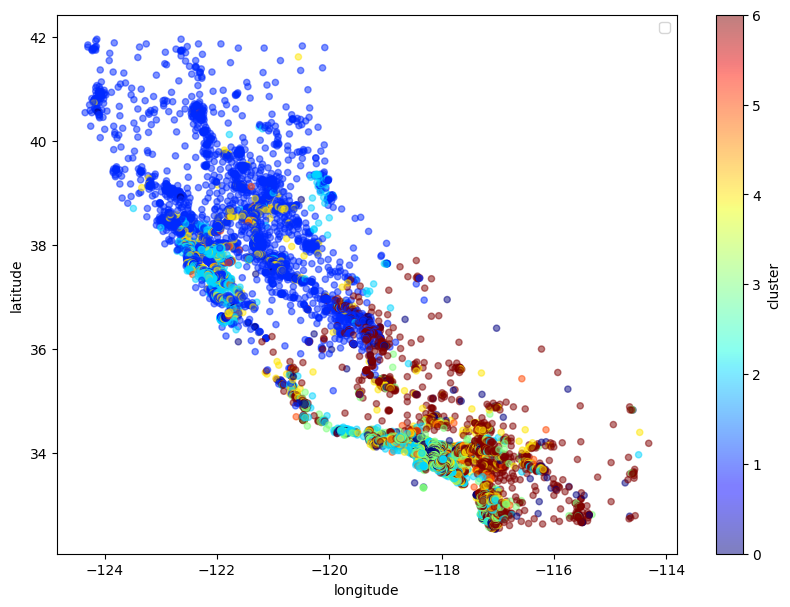



---8 MANY CLUSTERS---
the standard square error is 42277.78942638532
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.953468  35.298497           37.641106  4407.029644      637.598063   
1 -120.431997  34.698705           21.420065   772.195621      542.328403   
2 -120.283133  34.645221           23.475016  1607.573758      448.083706   
3 -117.748777  37.752664           29.371696  2384.272227      565.020011   
4 -120.323679  34.980330           30.915756  3821.765449      521.166463   
5 -112.481139  43.661255           31.800514  2874.144211      583.581548   
6 -120.238877  34.895433           61.790661  6942.990380     1182.411600   
7 -118.710375  36.438381           19.508776  2202.770706      255.023388   

    population   households  median_income  median_house_value  \
0  1393.570269   288.730951       5.291025       217698.825489   
1  1405.913224   490.650070       4.007275       301949.694843   
2  1447.587795   549.80

<ipython-input-10-fb4a0590dd97>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


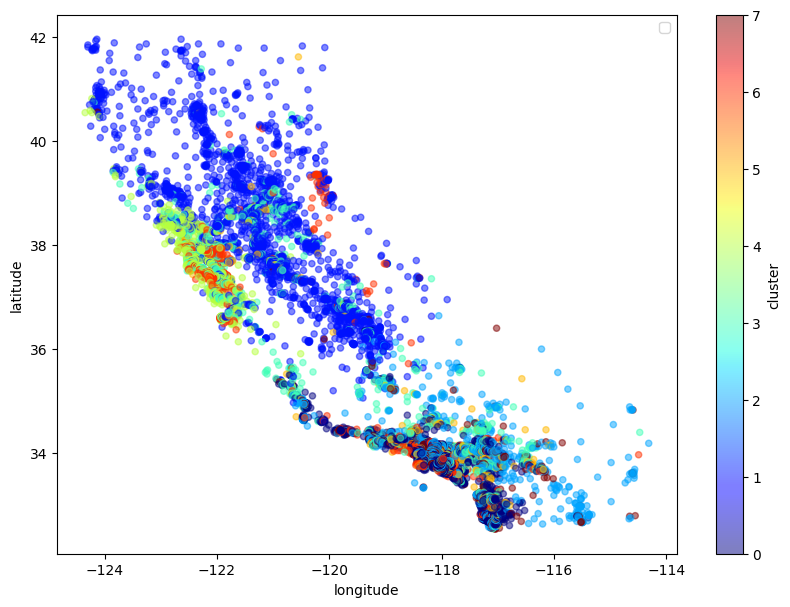



---9 MANY CLUSTERS---
the standard square error is 41242.2427288969
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.170478  35.795269           18.069717  2092.844461      207.129420   
1 -110.534473  45.661377           32.699832  2857.558185      617.047626   
2 -119.766405  35.439104           36.160512  3658.457406      637.587239   
3 -120.250642  34.957713           56.123835  6902.349743      975.365565   
4 -116.750429  38.973368           28.573142  2690.706870      511.191788   
5 -120.469075  34.820694           25.141143  2677.451818      468.590330   
6 -120.086670  34.880840           20.241052   462.851844      506.636739   
7 -120.291748  34.692890           25.549881  2477.489588      430.402546   
8 -119.928028  35.286683           26.261816  1570.642411      608.150077   

    population   households  median_income  median_house_value  \
0  1587.399824  1213.395168       5.206898       212137.411817   
1  1402.68310

<ipython-input-10-fb4a0590dd97>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


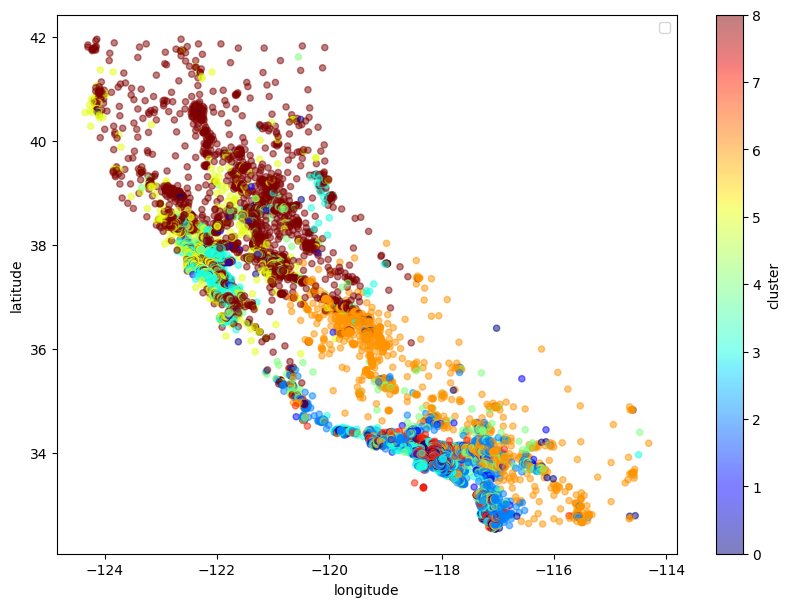



---10 MANY CLUSTERS---
the standard square error is 41168.62615274471
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -120.514047  34.792385           36.871879  4966.334352      579.457965   
1 -120.077245  35.075848           23.851999  1064.211475      571.439540   
2 -119.709052  35.377739           39.916139  3490.041402      730.016499   
3 -120.088052  35.148452           49.374503  5835.422273      753.159276   
4 -117.384154  38.222819           26.110180  2521.817384      451.711774   
5 -121.554787  33.521393           25.841628  1892.044878     5258.246991   
6 -113.912164  42.100414           32.440436  2917.957727      590.591633   
7 -105.806907  50.655843           34.831816  3142.518225      639.467824   
8 -120.425277  34.851742           23.178675  2304.551308      439.644996   
9 -119.912681  34.992642           20.797379  1596.302265      360.797343   

    population  households  median_income  median_house_value  \
0

<ipython-input-10-fb4a0590dd97>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


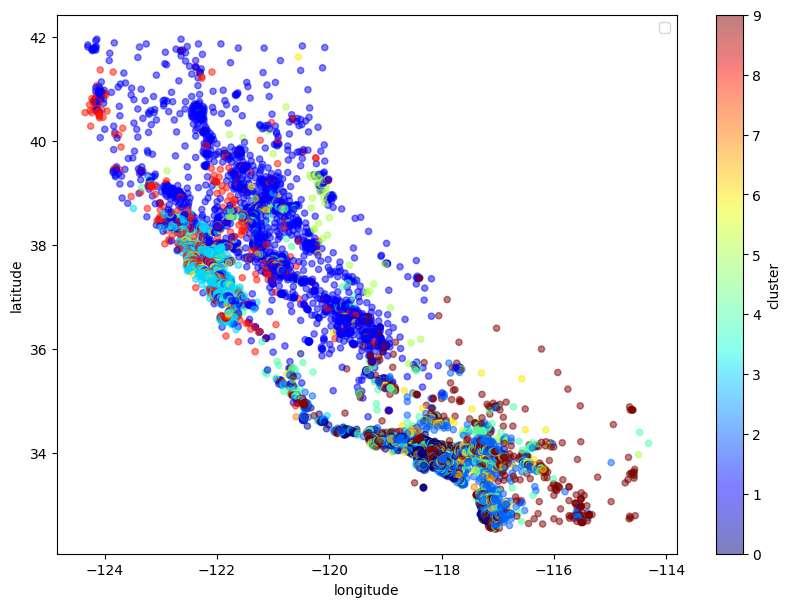

In [10]:
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
errors = {}
for k in ks:
  kmeans = MyKMeans(k, dist_algo="euclidean", iters=100)
  kmeans.fit(housing_prepared)

  housing_w_other_features = np.hstack((housing, housing_prepared[:,:7]))
  labeled = np.hstack((housing_w_other_features, kmeans.labels_.reshape(-1, 1)))
  labeled_df = pd.DataFrame(labeled, columns=feat_names + ['cluster'])

  errors[k] = kmeans.sse_
  print("---" + str(k) + " MANY CLUSTERS" + "---")
  print("the standard square error is " + str(kmeans.sse_))

  scaler = full_pipeline.named_transformers_["num"].named_steps["std_scaler"]
  cluster_vals = scaler.inverse_transform(np.array(kmeans.cluster_centers_)[:,5:])
  cluster_vals = np.hstack((cluster_vals, np.array(kmeans.cluster_centers_)[:,:5]))
  means = pd.DataFrame(cluster_vals, columns=feat_names)
  print("FEATURE MEANS")
  print(means)

  print("FEATURE STANDARD DEVIATIONS")
  print(pd.DataFrame(kmeans.sd_, columns=feat_names))

  labeled_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, figsize=(10,7),
      c="cluster", cmap=plt.get_cmap("jet"))
  plt.legend()
  plt.show()
  print('\n')

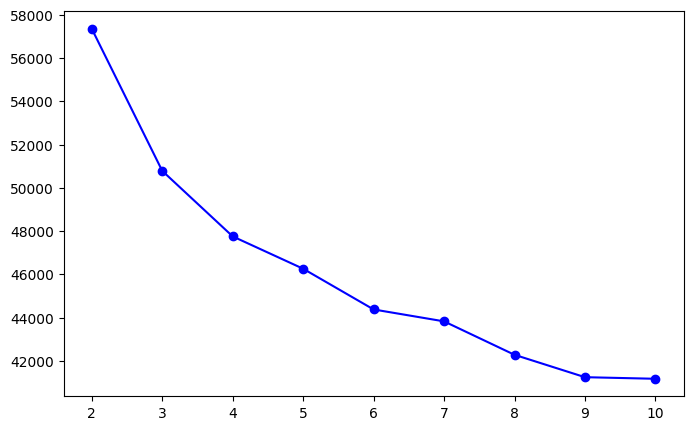

In [11]:
ks = list(errors.keys())
sse_values = list(errors.values())
plt.figure(figsize=(8, 5))
plt.plot(ks, sse_values, marker='o', linestyle='-', color='b')
plt.show()

##Manhattan Distance

---2 MANY CLUSTERS---
the standard square error is 175197.47208465287
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -120.092004  35.026619           28.338043  2587.471821      534.146795   
1 -116.146082  39.599169           30.615420  2952.307696      554.485061   

    population  households  median_income  median_house_value  \
0  1429.835452  500.054739       4.701213       243404.179503   
1  1396.905832  496.163516       4.779531       243982.569887   

   rooms_per_household  population_per_household  bedrooms_per_room  \
0             5.429691                  4.265938           0.222323   
1             5.429000                  3.941207           0.221365   

   NEAR OCEAN    ISLAND    INLAND  <1H OCEAN  NEAR BAY  
0   -0.028304  0.027047  0.130391  -0.272292 -0.282946  
1    0.185530 -0.177293 -0.854700   1.784845  1.854687  
FEATURE STANDARD DEVIATIONS
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \


<ipython-input-12-0d670256ccd7>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


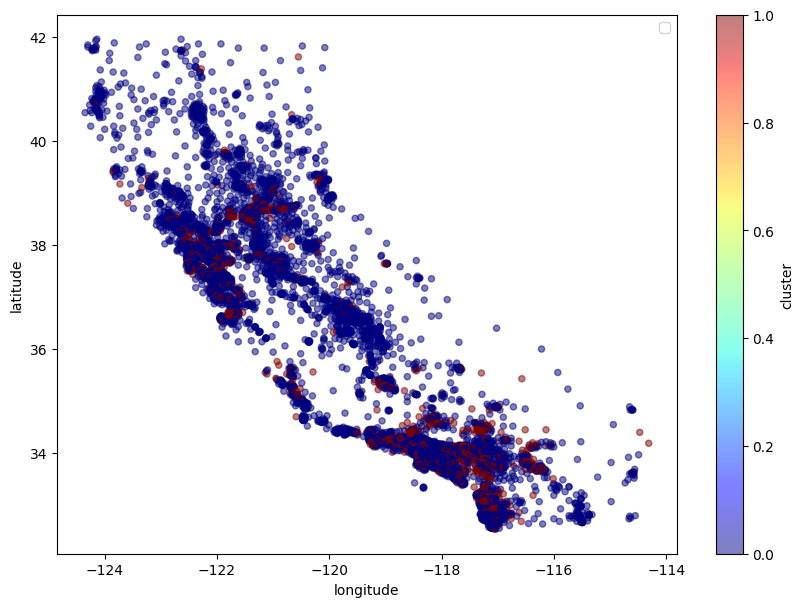



---3 MANY CLUSTERS---
the standard square error is 157273.92045336857
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -120.510853  34.499247           25.156758  2023.175603      503.823039   
1 -119.235686  36.191742           33.027183  3356.805218      598.020879   
2 -118.010568  37.353782           31.327347  3158.136451      543.166716   

    population  households  median_income  median_house_value  \
0  1449.989324  561.309357       4.716398       249515.721631   
1  1394.456419  380.049594       4.290803       244872.390212   
2  1406.693925  492.613295       5.113368       230027.870543   

   rooms_per_household  population_per_household  bedrooms_per_room  \
0             5.430191                  3.711581           0.221816   
1             5.429000                  6.449266           0.221890   
2             5.429000                  3.070655           0.223259   

   NEAR OCEAN    ISLAND    INLAND  <1H OCEAN  NEAR BAY  
0 

<ipython-input-12-0d670256ccd7>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


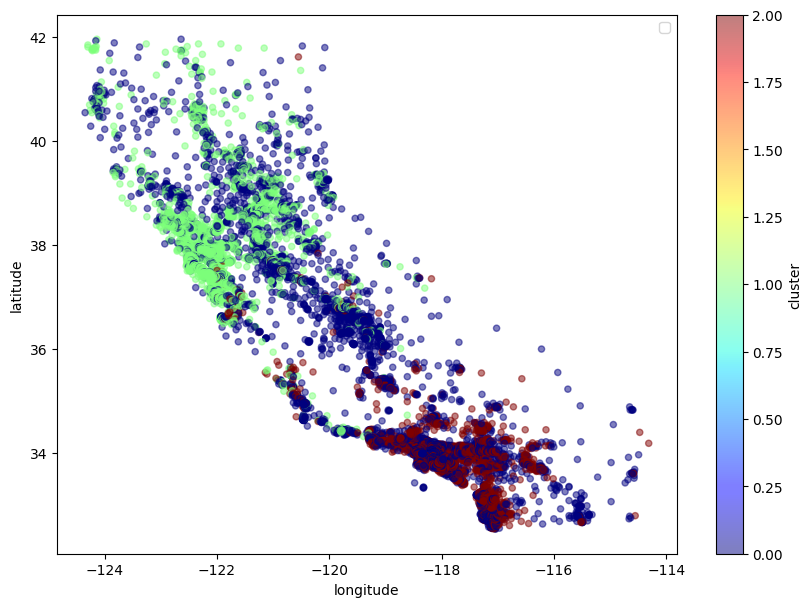



---4 MANY CLUSTERS---
the standard square error is 143434.15623743652
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -120.662201  34.434469           25.514762  1779.858878      592.805537   
1 -118.891528  36.608503           31.432585  3258.384182      556.793436   
2 -119.728250  35.360292           29.325114  2930.803148      492.682372   
3 -114.115778  41.848894           31.342453  2792.594282      583.660000   

    population  households  median_income  median_house_value  \
0  1450.398898  478.017781       4.093325       274571.478272   
1  1388.025515  416.798348       4.370359       242891.023533   
2  1425.358361  542.547180       5.177782       224361.992654   
3  1397.638057  454.513985       4.734823       252744.829491   

   rooms_per_household  population_per_household  bedrooms_per_room  \
0             5.429000                  5.287366           0.219179   
1             5.429000                  6.143435           0

<ipython-input-12-0d670256ccd7>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


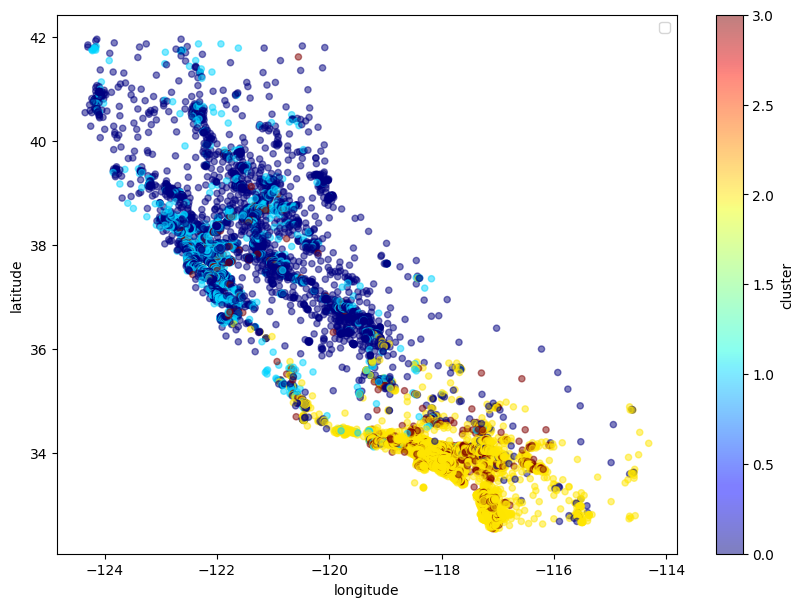



---5 MANY CLUSTERS---
the standard square error is 135574.76463641514
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -112.598290  43.474769           32.369396  2885.288204      589.885541   
1 -120.329693  34.888768           26.495230  2168.095698      579.329188   
2 -117.828997  37.730402           27.777586  2584.294539      517.056766   
3 -120.201094  34.935834           43.367156  4760.736883      712.352111   
4 -120.002932  34.929253           21.354336  1761.505589      375.292716   

    population  households  median_income  median_house_value  \
0  1400.193935  436.613641       4.679626       253252.633422   
1  1426.771780  462.789680       4.099197       264191.362291   
2  1395.726686  524.151472       4.757549       245272.174745   
3  1418.590007  218.058841       5.281919       218888.679983   
4  1447.550311  723.552285       5.020341       233772.374612   

   rooms_per_household  population_per_household  bedrooms_p

<ipython-input-12-0d670256ccd7>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


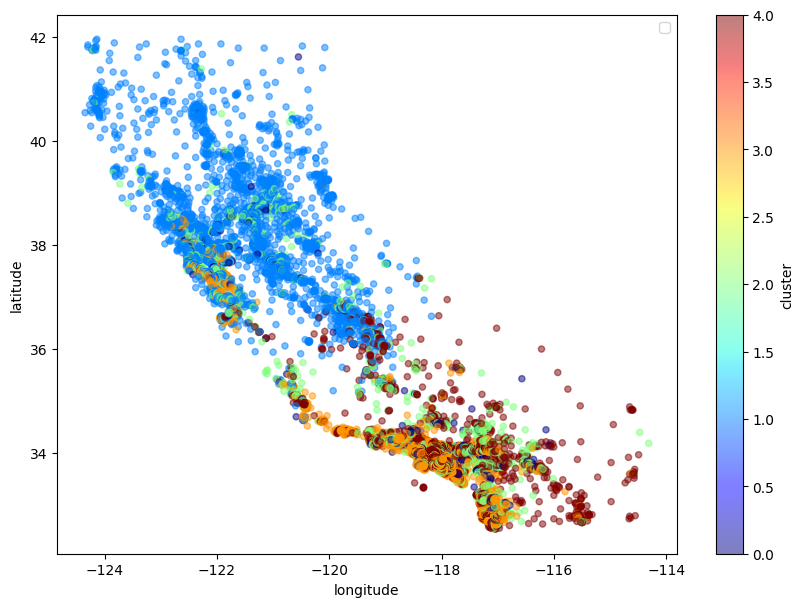



---6 MANY CLUSTERS---
the standard square error is 129576.55526639638
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.307379  35.930776           37.610309  3854.222218      660.979083   
1 -120.513638  34.603631           57.518326  6862.623587      862.459677   
2 -113.583451  42.465296           30.846439  2702.707320      573.093634   
3 -119.979202  35.426517           27.963673  3303.561600      468.864935   
4 -119.736734  35.283437           22.444868  2135.186360      360.295746   
5 -120.137771  34.993734           22.595264   817.801587      628.642198   

    population  households  median_income  median_house_value  \
0  1404.773833  270.409169       5.183767       225420.391872   
1  1445.374899  108.665712       4.886625       217110.974827   
2  1396.514163  461.342056       4.682523       255174.231481   
3  1380.852861  534.289277       4.349643       207463.325177   
4  1436.592665  731.633717       5.205087       2

<ipython-input-12-0d670256ccd7>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


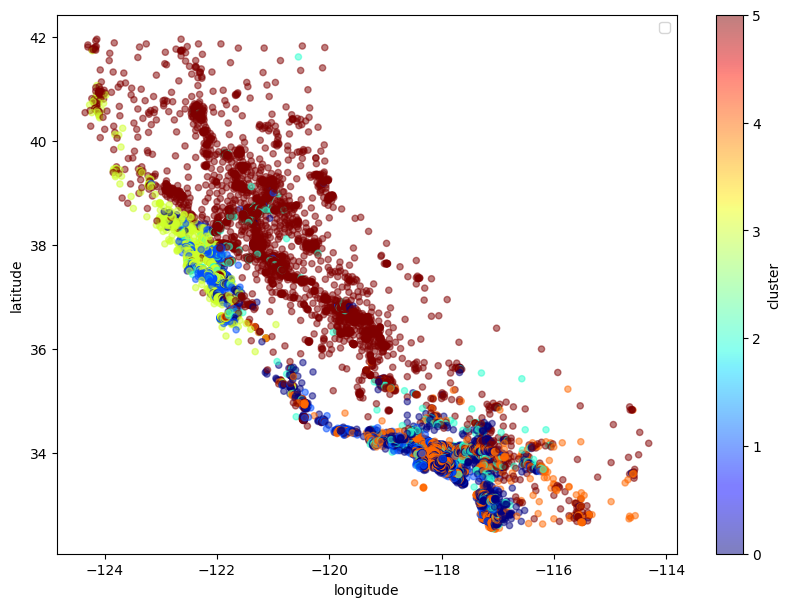



---7 MANY CLUSTERS---
the standard square error is 124143.84388566672
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -113.499270  42.537180           31.569256  2809.286133      572.717004   
1 -120.169934  34.958063           34.713543  3663.391640      585.472360   
2 -118.922425  36.397277           26.475291  2002.979927      563.718100   
3 -120.185959  34.943839           22.426834   808.936709      618.927275   
4 -119.437422  35.509105           19.226536  1952.025756      274.343835   
5 -119.897310  35.234075           60.626935  6967.081034      905.518007   
6 -119.948723  35.440336           29.140101  3435.727749      487.148271   

    population  households  median_income  median_house_value  \
0  1397.776529  448.483201       4.738005       252175.109411   
1  1411.534392  332.223036       5.473798       217114.137654   
2  1403.952282  459.295330       4.223694       252393.979750   
3  1457.038025  457.301795       3.92

<ipython-input-12-0d670256ccd7>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


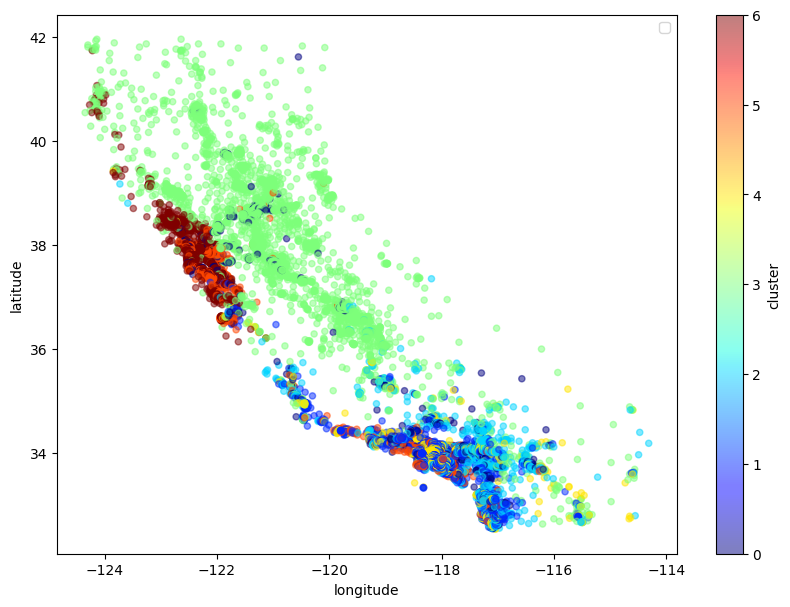



---8 MANY CLUSTERS---
the standard square error is 121020.48189793447
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -119.960346  35.028706           24.416233  2578.895645      373.835402   
1 -120.187457  35.176841           28.573226  3443.872459      475.383868   
2 -116.472281  39.342221           28.116065  2647.441364      484.453326   
3 -110.326220  45.884634           33.030418  2850.341357      633.048180   
4 -119.384725  35.804998           40.570922  4288.290260      701.024081   
5 -120.483148  34.648664           60.399580  7211.089365      881.410695   
6 -120.257072  34.868259           22.537636   858.556779      622.340613   
7 -119.777537  35.322171           22.988518  1179.151246      539.706387   

    population  households  median_income  median_house_value  \
0  1436.544838  697.395832       5.538461       209479.342712   
1  1380.409613  522.230266       4.290943       207338.166319   
2  1392.611705  551.60576

<ipython-input-12-0d670256ccd7>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


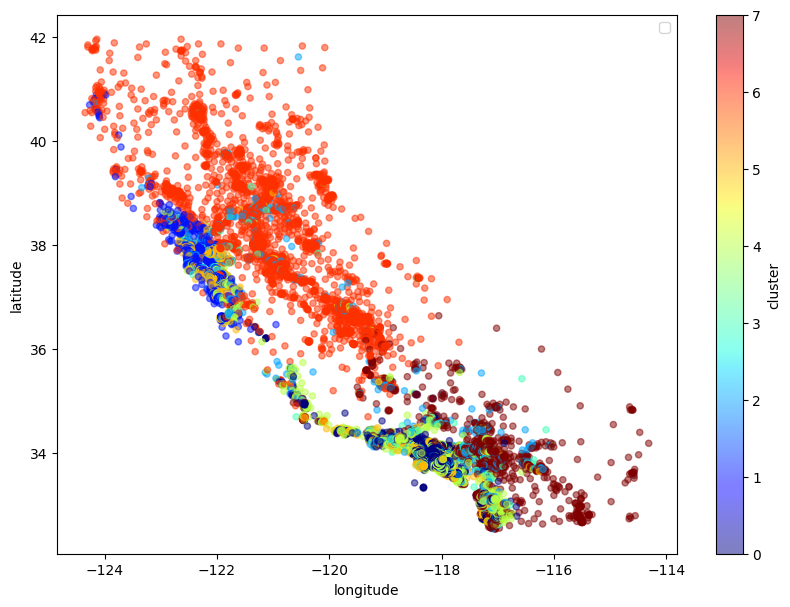



---9 MANY CLUSTERS---
the standard square error is 118454.90087208273
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -120.222520  35.175441           25.803974  3114.077868      432.032373   
1 -119.280623  35.891530           31.376634  1861.326059      761.884918   
2 -120.186832  34.773451           23.363717  2079.210912      393.819025   
3 -120.068468  35.123491           48.889947  5854.520843      769.914658   
4 -107.835419  48.552029           33.897604  3008.015765      635.149933   
5 -117.899134  37.536707           24.382045  2476.871349      408.811975   
6 -115.085360  40.837928           31.480268  2785.841277      574.882091   
7 -120.066143  35.106258           45.221493  5161.467830      731.459352   
8 -120.435002  34.662631           20.338226   609.894924      576.980048   

    population  households  median_income  median_house_value  \
0  1377.167563  594.327501       4.243293       207264.850144   
1  1415.29911

<ipython-input-12-0d670256ccd7>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


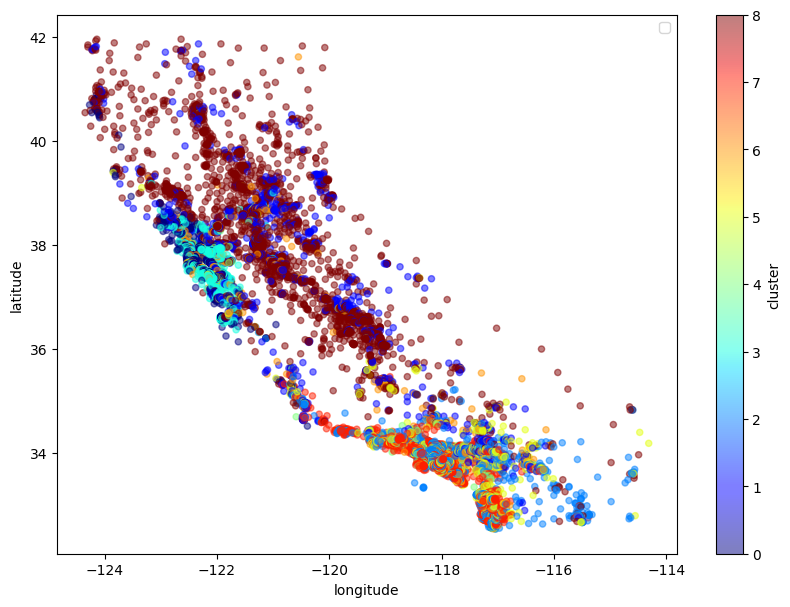



---10 MANY CLUSTERS---
the standard square error is 113584.0615738213
FEATURE MEANS
    longitude   latitude  housing_median_age  total_rooms  total_bedrooms  \
0 -120.338527  34.818463           23.113105   984.511717      649.406931   
1 -119.982768  35.001199           21.594051   639.165502      554.994953   
2 -119.627170  35.285815           19.231945  2000.666398      268.729352   
3 -117.015961  38.640807           27.249975  2700.976053      466.500892   
4 -120.308035  34.825841           32.027292  3374.732340      536.451627   
5 -120.210625  34.938357           48.082254  5613.371677      767.567394   
6 -117.071110  38.720252           30.702793  2841.644836      553.557503   
7 -120.248742  35.121883           25.564406  3078.861189      426.147907   
8 -119.734253  35.404557           53.632581  5984.623419      853.218252   
9 -109.793905  46.344306           33.025768  2798.148650      638.350408   

    population  households  median_income  median_house_value  \
0

<ipython-input-12-0d670256ccd7>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


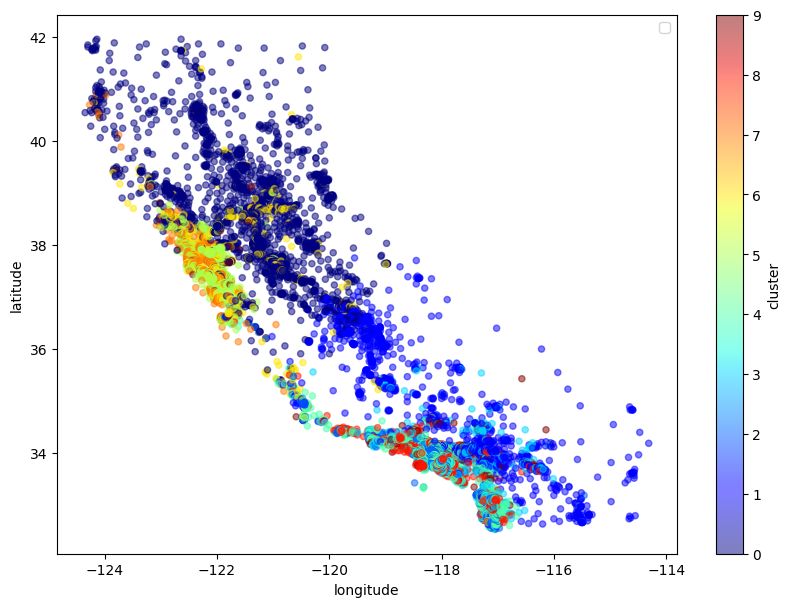

In [12]:
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
errors = {}
for k in ks:
  kmeans = MyKMeans(k, dist_algo="manhattan", iters = 100)
  kmeans.fit(housing_prepared)

  housing_w_other_features = np.hstack((housing, housing_prepared[:,:7]))
  labeled = np.hstack((housing_w_other_features, kmeans.labels_.reshape(-1, 1)))
  labeled_df = pd.DataFrame(labeled, columns=feat_names + ['cluster'])

  errors[k] = kmeans.sse_
  print("---" + str(k) + " MANY CLUSTERS" + "---")
  print("the standard square error is " + str(kmeans.sse_))

  scaler = full_pipeline.named_transformers_["num"].named_steps["std_scaler"]
  cluster_vals = scaler.inverse_transform(np.array(kmeans.cluster_centers_)[:,5:])
  cluster_vals = np.hstack((cluster_vals, np.array(kmeans.cluster_centers_)[:,:5]))
  means = pd.DataFrame(cluster_vals, columns=feat_names)
  print("FEATURE MEANS")
  print(means)

  print("FEATURE STANDARD DEVIATIONS")
  print(pd.DataFrame(kmeans.sd_, columns=feat_names))

  labeled_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, figsize=(10,7),
      c="cluster", cmap=plt.get_cmap("jet"))
  plt.legend()
  plt.show()
  print('\n')

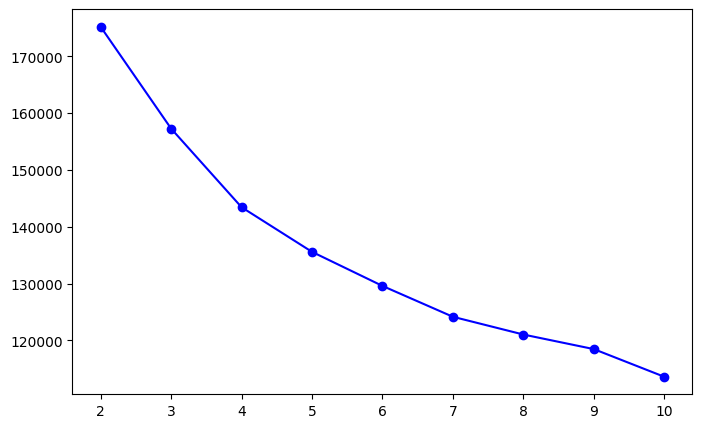

In [13]:
ks = list(errors.keys())
sse_values = list(errors.values())
plt.figure(figsize=(8, 5))
plt.plot(ks, sse_values, marker='o', linestyle='-', color='b')
plt.show()

##Part Four - The Crisis
We find that the optimal number of clusters is seven as the marginal value of additional clustering fails to justify the increased time spent fitting and runs the risk overfitting. Clusterings with too few clusters failed to precisely identify regions of greatest concern. Thus we proceed looking most closely at the results of clustering with seven clusters.

Based on our analysis, we can see that certain clusters of housing have a disproportionate ratio of population to household. Specifically, areas near the San Francisco Bay area and Los Angeles had an average of six to ten people per household, which is well above the state average of just under three people per household. This phenomenon was particularly occurrent in areas very close to the coast. Interestingly, these areas also tended to be those with lower median house values, possibly due to an inability of people to move elsewhere as a result of high housing prices.

Three possible paths forward are the following:
1. Support economic opportunities and the social desirability of areas with lower population to household ratios to encourage a natural balancing across the state. Such an effort could be defined by tax benefits for companies that offer remote work opportunities and state funding of cultural events such as concerts.
2. Support housing opportunities in areas with very high ratios of population to existing households. This plan may look like state supported high density housing projects or removal of zoning regulations that inhibit buildings from being over certain heights.
3. Support low income housing projects in areas with lower population to household ratios, thus enabling population flow to these areas rather than concentrating in the limited existing affordable areas.
